<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Softmax-exercise" data-toc-modified-id="Softmax-exercise-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Softmax exercise</a></span><ul class="toc-item"><li><span><a href="#Softmax-Classifier" data-toc-modified-id="Softmax-Classifier-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Softmax Classifier</a></span><ul class="toc-item"><li><span><a href="#code-for-details" data-toc-modified-id="code-for-details-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>code for details</a></span></li><li><span><a href="#Nested-loops-implementation" data-toc-modified-id="Nested-loops-implementation-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Nested loops implementation</a></span></li></ul></li><li><span><a href="#Inline-Question-1:" data-toc-modified-id="Inline-Question-1:-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Inline Question 1:</a></span><ul class="toc-item"><li><span><a href="#Loop-implementation-and-check" data-toc-modified-id="Loop-implementation-and-check-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Loop implementation and check</a></span></li><li><span><a href="#Compare-vectorized-and-loop-implementations" data-toc-modified-id="Compare-vectorized-and-loop-implementations-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Compare vectorized and loop implementations</a></span></li><li><span><a href="#Tune-parameters" data-toc-modified-id="Tune-parameters-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Tune parameters</a></span></li><li><span><a href="#Evaluation-on-test-set" data-toc-modified-id="Evaluation-on-test-set-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Evaluation on test set</a></span></li><li><span><a href="#Visualize-learned-rate" data-toc-modified-id="Visualize-learned-rate-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Visualize learned rate</a></span></li></ul></li></ul></li></ul></div>

# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
from __future__ import print_function

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    cifar10_train = cifar10_dir + '/data_batch'
    cifar10_test = cifar10_dir + '/test_batch'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_train, cifar10_test)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside **cs231n/classifiers/softmax.py**. 


### code for details

In [ ]:
from random import shuffle
from past.builtins import xrange

def softmax_loss_naive(W, X, y, reg):
  """
  Softmax loss function, naive implementation (with loops)

  Inputs have dimension D, there are C classes, and we operate on minibatches
  of N examples.

  Inputs:
  - W: A numpy array of shape (D, C) containing weights.
  - X: A numpy array of shape (N, D) containing a minibatch of data.
  - y: A numpy array of shape (N,) containing training labels; y[i] = c means
    that X[i] has label c, where 0 <= c < C.
  - reg: (float) regularization strength

  Returns a tuple of:
  - loss as single float
  - gradient with respect to weights W; an array of same shape as W
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using explicit loops.     #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  for i in range(num_train):
      scores = X[i,:].dot(W)
      probabilities = np.exp(scores)/np.sum(np.exp(scores))

      loss -= np.log(probabilities[y[i]])

      gradient_q = probabilities.reshape(1,-1)
      gradient_q[0, y[i]] += -1

      dW += X[i,:].reshape(-1,1).dot(gradient_q)

  loss /= num_train
  loss += reg * np.sum(W*W)

  dW /= num_train
  dW += 2 * reg * W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW


def softmax_loss_vectorized(W, X, y, reg):
  """
  Softmax loss function, vectorized version.

  Inputs and outputs are the same as softmax_loss_naive.
  """
  # Initialize the loss and gradient to zero.
  loss = 0.0
  dW = np.zeros_like(W)
  num_train = X.shape[0]

  #############################################################################
  # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
  # Store the loss in loss and the gradient in dW. If you are not careful     #
  # here, it is easy to run into numeric instability. Don't forget the        #
  # regularization!                                                           #
  #############################################################################
  scores = X.dot(W)
  exp_scores = np.exp(scores)
  probabilities = exp_scores / np.sum(exp_scores, axis = 1).reshape(-1, 1)

  loss -= np.sum(np.log(probabilities[range(num_train), y])) #data loss

  gradient_q = probabilities
  gradient_q[range(num_train), y] += -1
  dW = X.T.dot(gradient_q)

  loss /= num_train
  loss += reg * np.sum(W*W)

  dW /= num_train
  dW += 2 * reg * W
  #############################################################################
  #                          END OF YOUR CODE                                 #
  #############################################################################

  return loss, dW

### Nested loops implementation

In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.355897
sanity check: 2.302585


## Inline Question 1:
Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

**Your answer:** *10 classes are there and initially scores are almost same for all classes and so inside the -log denominator is 10 times the numerator and so we expect it to be close to -log(0.1)*


### Loop implementation and check

In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -0.959883 analytic: -0.959883, relative error: 3.490606e-08
numerical: 1.328026 analytic: 1.328026, relative error: 1.220768e-08
numerical: 1.787318 analytic: 1.787318, relative error: 5.374961e-09
numerical: 1.766693 analytic: 1.766693, relative error: 3.011076e-08
numerical: -1.968563 analytic: -1.968563, relative error: 2.135493e-08
numerical: 0.935833 analytic: 0.935833, relative error: 1.454285e-08
numerical: 1.503495 analytic: 1.503495, relative error: 3.874718e-08
numerical: 2.684472 analytic: 2.684472, relative error: 1.343545e-08
numerical: 0.704491 analytic: 0.704491, relative error: 3.932627e-08
numerical: 2.511196 analytic: 2.511196, relative error: 2.926923e-08
numerical: -2.327206 analytic: -2.327206, relative error: 3.805568e-09
numerical: 2.178743 analytic: 2.178743, relative error: 3.847384e-08
numerical: -1.183526 analytic: -1.183526, relative error: 3.306158e-08
numerical: -3.510644 analytic: -3.510644, relative error: 2.144026e-08
numerical: 1.401862 anal

### Compare vectorized and loop implementations

In [6]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.355897e+00 computed in 0.074956s
vectorized loss: 2.355897e+00 computed in 0.014000s
Loss difference: 0.000000
Gradient difference: 0.000000


### Tune parameters

In [7]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.
from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2e-7, 3e-7, 4e-7, 5e-7]
regularization_strengths = [1e4, 2.5e4, 4e4, 5e4]

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################
for lr_rt in learning_rates:
    for reg in regularization_strengths:
        softmax = Softmax()
        loss = softmax.train(X_train, y_train, learning_rate=lr_rt, reg=reg,
                      num_iters=500, verbose=False)
        
        tr_acc = np.mean(y_train == softmax.predict(X_train))
        val_acc = np.mean(y_val == softmax.predict(X_val))
        
        results[(lr_rt, reg)] = (tr_acc, val_acc)
        
        if (val_acc > best_val):
            best_val = val_acc
            best_softmax = softmax
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-07 reg 1.000000e+04 train accuracy: 0.254857 val accuracy: 0.274000
lr 1.000000e-07 reg 2.500000e+04 train accuracy: 0.307816 val accuracy: 0.318000
lr 1.000000e-07 reg 4.000000e+04 train accuracy: 0.310816 val accuracy: 0.315000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.309796 val accuracy: 0.330000
lr 2.000000e-07 reg 1.000000e+04 train accuracy: 0.330755 val accuracy: 0.336000
lr 2.000000e-07 reg 2.500000e+04 train accuracy: 0.334122 val accuracy: 0.359000
lr 2.000000e-07 reg 4.000000e+04 train accuracy: 0.318735 val accuracy: 0.332000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.307959 val accuracy: 0.321000
lr 3.000000e-07 reg 1.000000e+04 train accuracy: 0.349837 val accuracy: 0.364000
lr 3.000000e-07 reg 2.500000e+04 train accuracy: 0.331061 val accuracy: 0.353000
lr 3.000000e-07 reg 4.000000e+04 train accuracy: 0.316102 val accuracy: 0.332000
lr 3.000000e-07 reg 5.000000e+04 train accuracy: 0.310551 val accuracy: 0.322000
lr 4.000000e-07 reg 1.000000

### Evaluation on test set

In [8]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.373000


### Visualize learned rate

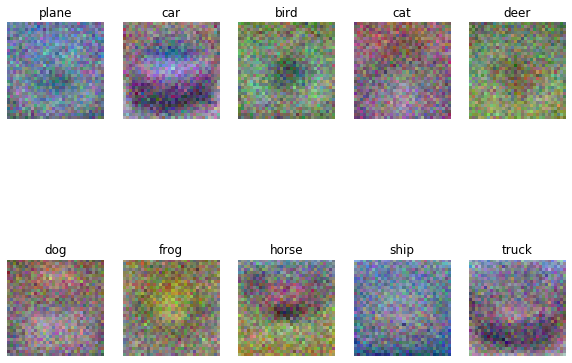

In [9]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])